In [2]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import bag
from tqdm import tqdm
from PIL import Image, ImageDraw

% matplotlib inline

In [3]:
def entropy_it(x):
    counts = np.bincount(x)
    p = counts[counts > 0] / float(len(x))
    # compute Shannon entropy in bits
    return -np.sum(p * np.log2(p))

def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            draw.line([stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]], fill=0, width=5)
    image = np.array(image)
    return entropy_it(image.flatten()), image

def plot_it(entropy, images, indices, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12, 10))
    for i, j in enumerate(indices[0][:n*n]):
        ax = axs[i // n, i % n]
        ax.set_title("%.4f" % entropy[j])
        ax.imshow(images[j], cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
        plt.setp(ax.spines.values(), color="red")
    plt.subplots_adjust(bottom=-0.2)
    plt.show()

In [5]:
reader = pd.read_csv('/Volumes/JS/QuickDraw/train_simplified/star.csv', index_col=['key_id'], chunksize=1024)

data = []
for chunk in tqdm(reader):
    entropybag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    data.extend(entropybag.compute()) # PARALLELIZE

entropy, images = zip(*data)

135it [02:16,  1.01s/it]


In [8]:
exclude= 1
lower = np.percentile(entropy, exclude)        # 0%~1% exclude the
upper = np.percentile(entropy, 100 - exclude)  # 99%~100%
print(np.min(entropy), np.max(entropy))
print(lower, upper)

0.0025374024260430028 0.9990242991302142
0.25751550265969386 0.5118598092447499


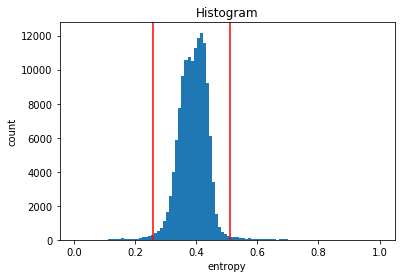

In [24]:
plt.title('Histogram')
plt.xlabel('entropy')
plt.ylabel('count')
plt.hist(entropy, bins=100)
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')

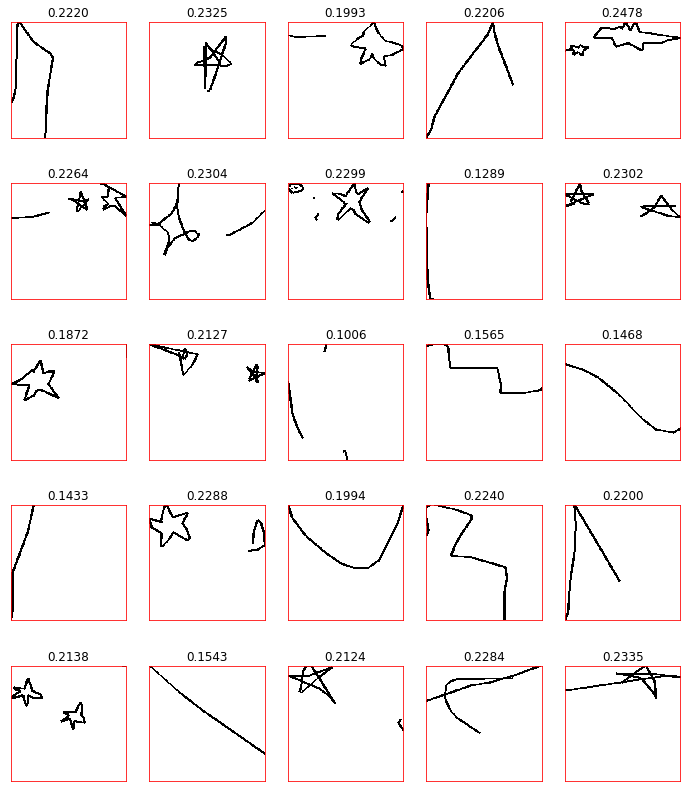

In [10]:
plot_it(entropy, images, np.where(entropy < lower))

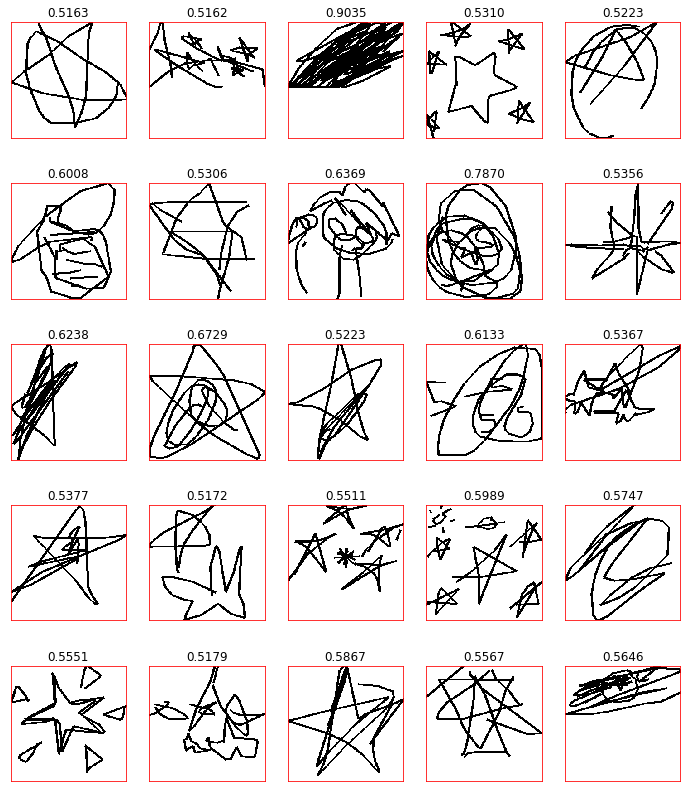

In [20]:
plot_it(entropy, images, np.where(entropy > upper))

In [26]:
np.where(entropy < lower)[0]

array([    33,    498,    503, ..., 137297, 137396, 137471])

In [19]:
np.where(entropy > upper)[0].shape

(1376,)

In [25]:
np.where(entropy > upper)[0]

array([    46,    123,    149, ..., 137544, 137588, 137610])

In [31]:
images[33].shape

(256, 256)

In [52]:
reader = pd.read_csv('/Volumes/JS/QuickDraw/train_simplified/star.csv', nrows=100)

In [65]:
drawing = reader['drawing'][46]
drawing = eval(drawing)

In [66]:
import nbimporter
from DataParserForCNN import drawing_to_image

In [67]:
img = drawing_to_image(drawing, H=64, W=64)

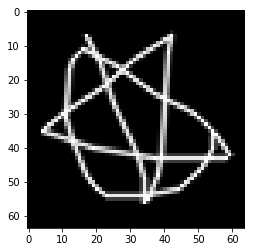

In [68]:
plt.imshow(img.astype('uint8'))